## 5.5 顧客層に応じた販売戦略(クラスタリング、次元圧縮)


### 2023-1105追加分
Google Colabで過去のバージョンが動くようにします  
scikit-lean: 0.23.2

#### 環境変数設定

In [2]:
import os
path_org = os.environ['PATH']
path_38 = '/usr/local_py38'
path_38bin = f'{path_38}/bin'
os.environ['PATH'] = f'{path_38bin}:{path_org}'

import sys
sys.path.append(f'{path_38}/lib/python3.8/site-packages')

#### conda導入

In [2]:
!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh | tail -n 1
!chmod +x mini.sh
!bash ./mini.sh -b -f -p $path_38 | tail -n 1

--2023-11-05 01:03:53--  https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89817099 (86M) [application/x-sh]
Saving to: ‘mini.sh’

mini.sh             100%[===================>]  85.66M   134MB/s    in 0.6s    

2023-11-05 01:03:54 (134 MB/s) - ‘mini.sh’ saved [89817099/89817099]

    in Miniconda3: /usr/local_py38


In [3]:
# 結果確認
!which conda
!which pip

/usr/local_py38/bin/conda
/usr/local_py38/bin/pip


#### ライブラリ追加導入

In [4]:
!conda install -q -y conda python=3.8 --prefix $path_38 | tail -n 1
!conda install -q -y jupyter --prefix $path_38 | tail -n 1
!conda install -q -y google-colab -c conda-forge --prefix $path_38 | tail -n 1

Executing transaction: ...working... done
Executing transaction: ...working... done
Executing transaction: ...working... done


#### カーネル追加

In [4]:
!python -m ipykernel install --name "py38" --user
# 結果確認
!jupyter-kernelspec list

Installed kernelspec py38 in /root/.local/share/jupyter/kernels/py38
Available kernels:
  py38       /root/.local/share/jupyter/kernels/py38
  python3    /usr/local_py38/share/jupyter/kernels/python3
  ir         /usr/local/share/jupyter/kernels/ir


#### カーネル切替え

In [ ]:
 # UI経由で実施
 # メニューから「ランタイム」「ランタイムのタイプを変更」
 # ランタイムのタイプ: 「Python 3」→「py38」 で「保存」

In [1]:
# 新カーネルの動作テスト
1+1

2

 #### 環境変数再設定

In [2]:
# sys.pathの設定を確認
# 次の設定は不要
# sys.path.append(f'{path_38}/lib/python3.8/site-packages')

import sys
print(f'Python Version: {sys.version}')
for path in sys.path:
    print(path)

Python Version: 3.8.18 (default, Sep 11 2023, 13:20:55) 
[GCC 11.2.0]
/content
/env/python
/usr/local_py38/lib/python38.zip
/usr/local_py38/lib/python3.8
/usr/local_py38/lib/python3.8/lib-dynload

/usr/local_py38/lib/python3.8/site-packages


In [3]:
import os
path_org = os.environ['PATH']
path_38 = '/usr/local_py38'
path_38bin = f'{path_38}/bin'
os.environ['PATH'] = f'{path_38bin}:{path_org}'
# 設定確認
print(os.environ['PATH'])

/usr/local_py38/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin


#### ライブラリ追加導入#2

In [4]:
!conda install -q -y scikit-learn==0.23.2 --prefix $path_38 | tail -n 1
!conda install -q -y matplotlib --prefix $path_38 | tail -n 1

Executing transaction: ...working... done
Executing transaction: ...working... done


#### バージョン確認

In [5]:
import sklearn
print(sklearn.__version__)
from sklearn.cluster import KMeans

0.23.2


### 共通事前処理

In [7]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib | tail -n 1

In [8]:
# 共通事前処理

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)

# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format

# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14

# 乱数の種
random_seed = 123

### オリジナルURL
Wholesale customers Data Set

https://archive.ics.uci.edu/ml/datasets/wholesale+customers

### 5.5.4 データ読み込みからデータ確認まで

#### データ読み込み

In [9]:
# データ読み込み
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases\
/00292/Wholesale%20customers%20data.csv'

df = pd.read_csv(url)

# 日本語に変更
columns = ['販売チャネル', '地域', '生鮮食品', '乳製品', '食料品',
    '冷凍食品', '洗剤_紙製品', '総菜']
df.columns = columns

#### データ確認

In [10]:
# データ内容確認
display(df.head())

# サイズ確認
print(df.shape)

,販売チャネル,地域,生鮮食品,乳製品,食料品,冷凍食品,洗剤_紙製品,総菜
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


(440, 8)


In [11]:
# 欠損値確認
print(df.isnull().sum())

販売チャネル    0
地域        0
生鮮食品      0
乳製品       0
食料品       0
冷凍食品      0
洗剤_紙製品    0
総菜        0
dtype: int64


In [12]:
# 販売チャネルのコード値確認
print(df['販売チャネル'].value_counts())
print()

# 地域のコード値確認
print(df['地域'].value_counts())

1    298
2    142
Name: 販売チャネル, dtype: int64

3    316
1     77
2     47
Name: 地域, dtype: int64


#### 販売チャネルのコード値の意味
1.  Horeca(ホテル・レストラン・カフェ) 298
2. Retail(小売り) 142

#### 地域のコード値の意味
1.  Lisbon(リスボン) 77
2. Oporto(オプルトまたはポルト) 47
3. Other Region(その他) 316



#### ヒストグラム表示

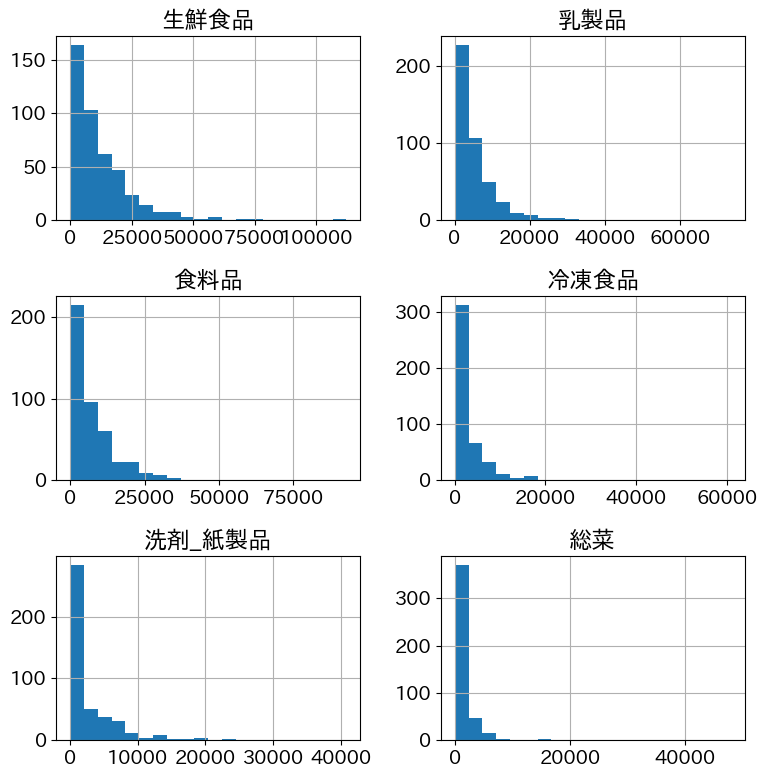

In [13]:
# 販売チャネルと地域を落としたデータを作る
df2 = df.drop(['販売チャネル', '地域'], axis=1)

# 分析対象項目のヒストグラム表示
from pylab import rcParams
rcParams['figure.figsize'] = (8, 8)
df2.hist(bins=20)
plt.tight_layout()
plt.show()

### 5.5.5 クラスタリングの実施

In [14]:
# データ前処理とデータ分割は不要

# アルゴリズムの選択
from sklearn.cluster import KMeans

# グループ数を定義
clusters=4

# アルゴリズムの定義
algorithm = KMeans(n_clusters=clusters,
    random_state=random_seed)

In [15]:
# 学習、予測の実施
y_pred = algorithm.fit_predict(df2)

# 結果の一部確認
print(y_pred[:20])

[3 3 3 3 0 3 3 3 3 1 1 3 0 1 0 3 1 3 3 3]


### 5.5.6 クラスタリング結果の分析

#### グループ別平均値計算

In [16]:
# グループごとの平均値計算
df_cluster = df2.groupby(y_pred).mean()
display(df_cluster)

,生鮮食品,乳製品,食料品,冷凍食品,洗剤_紙製品,総菜
0,36156.3898,6123.6441,6366.7797,6811.1186,1050.0169,3090.0508
1,5134.2198,11398.0769,17848.7582,1562.7802,7768.9231,1900.2418
2,20031.2857,38084.0000,56126.1429,2564.5714,27644.5714,2548.1429
3,8973.3958,3128.0883,3907.4276,2790.2085,1079.2297,1052.5477


#### グループ別グラフ表示

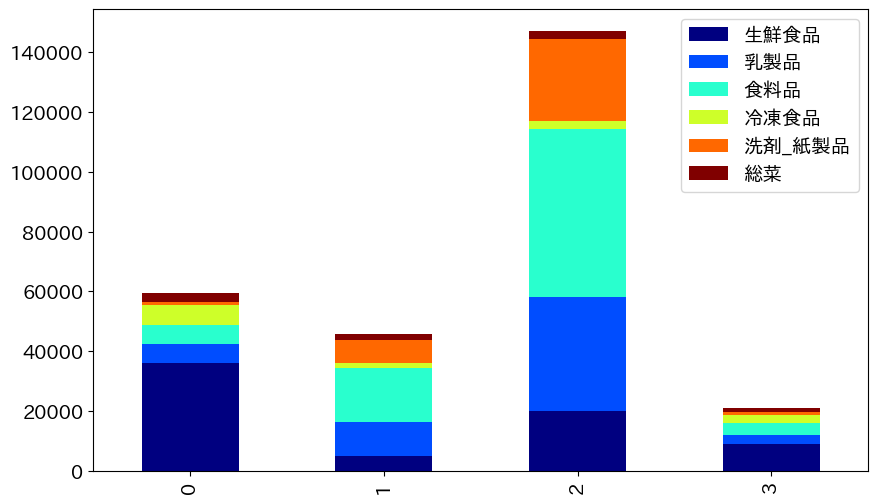

In [17]:
# グループ別の棒グラフ表示
df_cluster.plot(kind='bar',stacked=True,
    figsize=(10, 6),colormap='jet')
plt.show()

#### 分析結果

* **0**: 生鮮食品中心
* **1**: 食料品中心
* **2**: 大量購入
* **3**: 少量購入

#### グループと販売チャネル・地域との関係

==== グループ0 ====


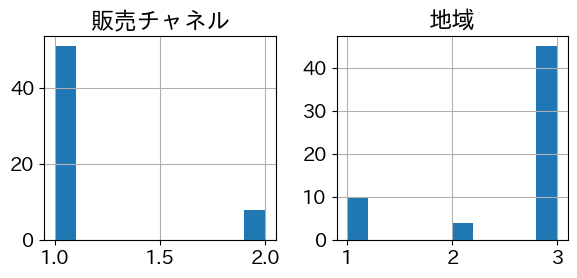

==== グループ1 ====


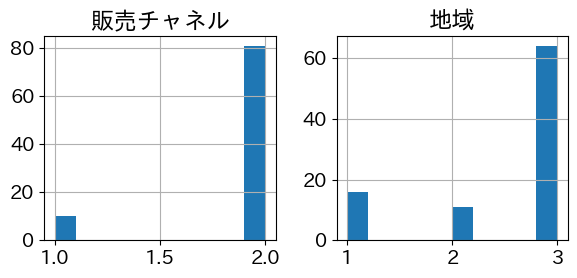

==== グループ2 ====


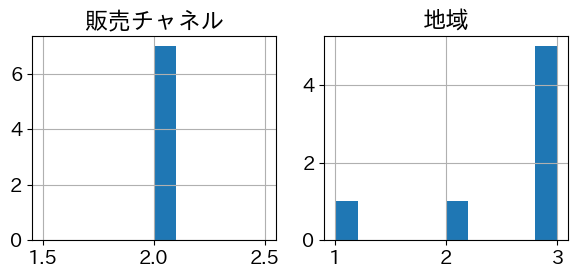

==== グループ3 ====


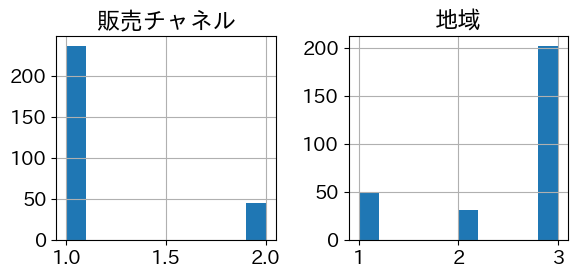

In [18]:
# クラスタと、チャネル・地域の関係を調べる

# 販売チャネルと地域のみをdf3に抽出
df3 = df[['販売チャネル', '地域']]

# グラフの大きさ設定
rcParams['figure.figsize'] = (6,3)

# グループごとのグラフ表示
for i in range(clusters):
    fig, ax = plt.subplots()
    w = df3[y_pred==i]
    print(f'==== グループ{i} ====')
    w.hist(ax=ax)
    plt.tight_layout()
    plt.show()

#### 分析結果
グループ0(生鮮)とグループ3(少量)は、チャネル1(Horeca)と関連が深い。   
グループ1(食品)とグループ2(大量)は、チャネル2(Retail)と関連が深い。  
地域とグループの関連は時に見いだせない。

### 5.5.7 次元圧縮の実施

In [19]:
# アルゴリズムの選択
from sklearn.decomposition import PCA

# モデル生成
# 散布図表示が目的のため2次元に圧縮
pca = PCA(n_components=2)

In [20]:
# 学習・変換の実施
d2 = pca.fit_transform(df2)

# 結果の一部表示
print(d2[:5,:])

[[  650.0221  1585.5191]
 [-4426.805   4042.4515]
 [-4841.9987  2578.7622]
 [  990.3464 -6279.806 ]
 [10657.9987 -2159.7258]]


### 5.5.8 次元圧縮の活用方法

#### 散布図表示

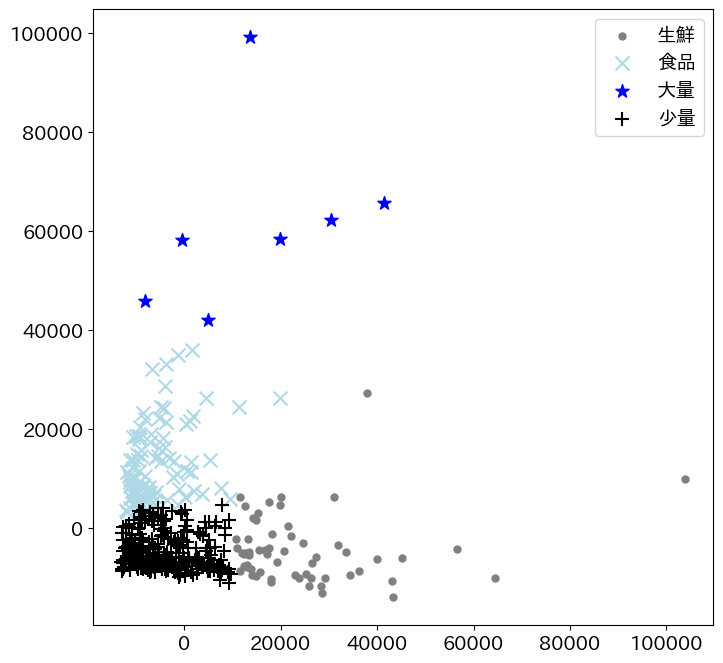

In [21]:
# グループごとに色分けし散布図表示

plt.figure(figsize=(8,8))
marks = ['.', 'x', '*', '+']
labels = ['生鮮', '食品', '大量', '少量']
colors = ['grey', 'lightblue', 'blue', 'black']
for i in range(clusters):
  plt.scatter(d2[y_pred==i][:,0], d2[y_pred==i][:,1],
    marker=marks[i], label=labels[i], s=100, c=colors[i])
plt.legend(fontsize=14)
plt.show()

#### 例外値の調査

In [22]:
# 生鮮グループの例外値を調べる
display(df[d2[:,0] > 100000])

,販売チャネル,地域,生鮮食品,乳製品,食料品,冷凍食品,洗剤_紙製品,総菜
181,1,3,112151,29627,18148,16745,4948,8550


【考察】  
インデックス181の顧客は、特に生鮮食品の購買量が多いと考えられる

In [23]:
# 大量グループの例外値を調べる
display(df[d2[:,1] > 80000])

,販売チャネル,地域,生鮮食品,乳製品,食料品,冷凍食品,洗剤_紙製品,総菜
85,2,3,16117,46197,92780,1026,40827,2944


【考察】  
インデックス85の顧客は、特に食料品と洗剤・紙製品の購買量が多いと考えられる

In [24]:
# 統計情報確認
display(df2.describe())

,生鮮食品,乳製品,食料品,冷凍食品,洗剤_紙製品,総菜
count,440.0000,440.0000,440.0000,440.0000,440.0000,440.0000
mean,12000.2977,5796.2659,7951.2773,3071.9318,2881.4932,1524.8705
std,12647.3289,7380.3772,9503.1628,4854.6733,4767.8544,2820.1059
min,3.0000,55.0000,3.0000,25.0000,3.0000,3.0000
25%,3127.7500,1533.0000,2153.0000,742.2500,256.7500,408.2500
50%,8504.0000,3627.0000,4755.5000,1526.0000,816.5000,965.5000
75%,16933.7500,7190.2500,10655.7500,3554.2500,3922.0000,1820.2500
max,112151.0000,73498.0000,92780.0000,60869.0000,40827.0000,47943.0000


In [25]:
### バージョン確認

In [27]:
import sys
!pip install watermark | tail -n 1
%load_ext watermark
%watermark --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
sys                : 3.8.18 (default, Sep 11 2023, 13:20:55) 
[GCC 11.2.0]
numpy              : 1.22.3
matplotlib         : 3.7.2
japanize_matplotlib: 1.1.3
sklearn            : 0.23.1
pandas             : 1.3.5

